# Do not update the first cell (it's related to surface/formation structure)

In [1]:
%load_ext autoreload
%autoreload 2
#### DO NOT UPDATE THIS CELL ########
import matplotlib.pyplot as plt
import numpy as np
from reservoir_grid import Stratigraphy_Grid
from scipy.spatial import Delaunay
import trimesh

# now you can play with this workflow below

In [2]:
top_2 = np.loadtxt('dataset/west_sea_2024/Base_SU7_middle_Miocene.dat')


In [3]:
top_2[0]

array([6.39050000e+05, 3.97535000e+06, 7.43975342e+02])

In [4]:
top_2 = np.loadtxt('dataset/west_sea_2024/Base_SU7_middle_Miocene.dat')
top_2[:,2] *= -10
top = np.loadtxt('dataset/west_sea_2024/Base_SU6_Interbedded_Seal.dat')
top[:,2] *= -10
bottom = np.loadtxt('dataset/west_sea_2024/Base_SU5_Top_Cretaceous.dat')
bottom[:,2] *= -10

In [5]:
top_2_pts = top_2[:,0:2]
top_2_pts_3d = top_2

top_pts = top[:,0:2]
top_pts_3d = top
bottom_pts = bottom[:,0:2]
bottom_pts_3d = bottom

top_2_tri = Delaunay(top_2_pts)
top_tri = Delaunay(top_pts)
bottom_tri = Delaunay(bottom_pts)

top_2 = trimesh.Trimesh(vertices=top_2_pts_3d,
                    faces=top_2_tri.simplices,
                    process=True)

top = trimesh.Trimesh(vertices=top_pts_3d,
                    faces=top_tri.simplices,
                    process=True)
bottom = trimesh.Trimesh(vertices=bottom_pts_3d,
                    faces=bottom_tri.simplices,
                    process=True)


In [6]:
from _visualize_surface import visualize_surface

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
# visualize_surface([top_2, top, bottom])

In [8]:
# heading_to_sky = np.array([0, 0, 1])
# angles = np.arccos(np.sum(top.face_normals*heading_to_sky,axis = 1))

# angle_in_deg = np.rad2deg(angles)

# threshold_to_tell_disconnect = np.percentile(angle_in_deg,98)
# flag_of_fault_ = angle_in_deg > threshold_to_tell_disconnect
# top_new = trimesh.Trimesh(vertices=top_pts_3d,
#                     faces=top_tri.simplices[~flag_of_fault_],
#                     process=True)

In [9]:
# heading_to_sky = np.array([0, 0, 1])
# angles = np.arccos(np.sum(top.face_normals*heading_to_sky,axis = 1))

# flag_of_fault_candidates = np.rad2deg(angles)

# fault_tri_indices = np.where(flag_of_fault_candidates)[0]
# neighbors = top_tri.neighbors

# average_normals = []
# for face_index in fault_tri_indices:
#     neighbor_faces = neighbors[face_index]

#     # 유효한 인접 삼각형들만 선택 (-1 제외)
#     valid_neighbors = [idx for idx in neighbor_faces if idx != -1]

#     # 현재 삼각형과 인접 삼각형들의 법선 벡터 리스트 생성
#     all_normals = [top.face_normals[face_index]]  # 현재 삼각형 포함
#     all_normals.extend([top.face_normals[idx] for idx in valid_neighbors])

#     # 평균 법선 벡터 계산 후 정규화
#     avg_normal = np.mean(all_normals, axis=0)
#     avg_normal = avg_normal / np.linalg.norm(avg_normal)  # 정규화

#     average_normals.append(avg_normal)

# average_normals = np.array(average_normals)

# # 평균 법선 벡터와 Z축과의 각도를 다시 계산
# angles_avg = np.arccos(np.clip(np.sum(average_normals * heading_to_sky, axis=1), -1.0, 1.0))
# angle_in_deg_avg = np.rad2deg(angles_avg)

# # 98번째 백분위수를 기준으로 최종 Threshold 설정
# threshold_final = np.percentile(angle_in_deg_avg, 98)

# # 최종적으로 기울어진 삼각형들 필터링
# final_fault_flags = angle_in_deg_avg > threshold_final

# # Fault가 아닌 삼각형만 유지하여 새로운 지표면 생성
# filtered_faces = np.array(fault_tri_indices)[~final_fault_flags]  # Fault가 아닌 삼각형 인덱스만 선택
# top_new = trimesh.Trimesh(vertices=top_pts_3d,
#                           faces=top_tri.simplices[filtered_faces],
#                           process=True)

In [ ]:
heading_to_sky = np.array([0, 0, 1])

angles = np.arccos(np.clip(np.sum(top.face_normals * heading_to_sky, axis=1), -1.0, 1.0))
angle_in_deg = np.rad2deg(angles)

threshold_to_tell_disconnect = np.percentile(angle_in_deg, 98)
fault_tri_indices = np.where(angle_in_deg > threshold_to_tell_disconnect)[0]  # 기울어진 삼각형 인덱스

# 2️⃣ 꼭짓점(Vertex)별로 해당하는 삼각형을 찾기
vertex_to_faces = {i: [] for i in range(len(top.vertices))}  # 각 점이 포함된 삼각형 리스트
for face_idx, simplex in enumerate(top_tri.simplices):
    for vertex in simplex:
        vertex_to_faces[vertex].append(face_idx)

# 3️⃣ 꼭짓점(Vertex)별 평균 법선 벡터 계산
vertex_normals = np.zeros_like(top.vertices)
for vertex, faces in vertex_to_faces.items():
    normals = [top.face_normals[f] for f in faces]  # 해당 점이 포함된 삼각형들의 법선 벡터 리스트
    avg_normal = np.mean(normals, axis=0)  # 평균 법선 벡터 계산
    vertex_normals[vertex] = avg_normal / np.linalg.norm(avg_normal)  # 정규화

# 4️⃣ 각 삼각형의 꼭짓점(Vertex)들의 평균 법선 벡터를 이용하여 삼각형의 평균 법선 벡터 계산
triangle_avg_normals = np.zeros_like(top.face_normals)
for i, simplex in enumerate(top_tri.simplices):
    triangle_avg_normals[i] = np.mean(vertex_normals[simplex], axis=0)  # 삼각형을 이루는 3개의 점의 평균 법선 벡터

# 5️⃣ 평균 법선 벡터와 Z축과의 각도 계산
angles_avg = np.arccos(np.clip(np.sum(triangle_avg_normals * heading_to_sky, axis=1), -1.0, 1.0))
angle_in_deg_avg = np.rad2deg(angles_avg)

# 98번째 백분위수를 기준으로 최종 Threshold 설정
threshold_final = np.percentile(angle_in_deg_avg, 98)

# ✅ 각도가 큰 삼각형만 필터링
final_fault_flags = angle_in_deg_avg > threshold_final  # ✅ 각도가 큰 삼각형만 True로 선택
# final_fault_flags = final_fault_flags[:fault_tri_indices.shape[0]]

# filtered_faces = np.array(fault_tri_indices)[final_fault_flags]  # ✅ 각도가 큰 삼각형만 유지

# Fault가 아닌 삼각형만 유지하여 새로운 지표면 생성
top_new = trimesh.Trimesh(vertices=top_pts_3d,
                          faces=top_tri.simplices[~final_fault_flags],
                          process=True)



In [41]:
final_fault_flags = angle_in_deg_avg > threshold_final

In [42]:
final_fault_flags

array([False, False, False, ..., False, False, False], shape=(223580,))

In [45]:
visualize_surface([top_new])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [15]:

# # Define a function to handle the click event
# def onclick(event):
#     if event.xdata is not None and event.ydata is not None:
#         print(f"Clicked point: ({event.xdata}, {event.ydata})")


# fig, ax = plt.subplots(1,2)

# for i, surf in enumerate([top_pts_3d, bottom_pts_3d]):
    
#     ax[i].scatter(surf[:,0],
#                 surf[:,1],
#                 c = surf[:,2],
#                 s = 4)
#     plt.plot([x0,x0,x1,x1, x0], [y0, y1, y1, y0, y0], 'r-', linewidth=2)
# plt.tight_layout()
# # Connect the click event to the function
# cid = fig.canvas.mpl_connect('button_press_event', onclick)

# plt.show()

In [16]:
x0 = max(639484.0417479295, 639673.5766733686)
x1 = min(648283.877571888, 648040.1898106091)
y0 = max(3986237.336147831, 3986917.2039575293)
y1 = min(3990951.0862950725, 33990588.4901299)


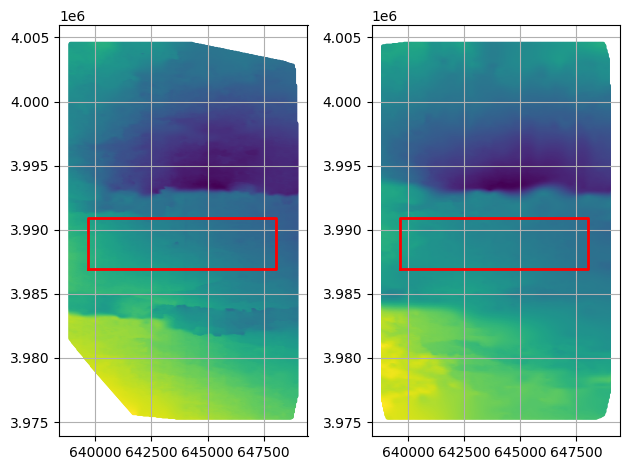

In [17]:
# %matplotlib inline
for i, surf in enumerate([top_pts_3d, bottom_pts_3d], 1):
    plt.subplot(1,2,i)
    plt.scatter(surf[:,0],
                surf[:,1],
                c = surf[:,2],
                s = 4)
    plt.plot([x0,x0,x1,x1, x0], [y0, y1, y1, y0, y0], 'r-', linewidth=2)
    plt.grid('on')
plt.tight_layout()
plt.show()

In [18]:
nx, ny, nz = 100, 100, 16

grid = Stratigraphy_Grid(num_grid = [nx, ny, nz], extent = [x0, x1, y0, y1], positive_depth = False)
grid.load_horizons(top,'top')
grid.load_horizons(bottom,'bottom')
grid.cmg_corner_point_generate('top','bottom')
grid.load_xx_yy_zz('top','bottom')

TypeError: Stratigraphy_Grid.load_xx_yy_zz() missing 1 required positional argument: 'fault_x'

In [ ]:
# quick check the structure grid
grid.visual_3D_from_formation_grid('top_to_bottom_formation',vertical_colorbar =False, aspect_ratio= 1)

Widget(value='<iframe src="http://localhost:60581/index.html?ui=P_0x2317e907b00_2&reconnect=auto" class="pyvis…

In [ ]:
grid.write_cmg_corner_points_input_file('.','top_to_bottom_formation')

In [ ]:
# load porosity and facies model whose size is 16x32x32 in z-, y-, and x-direction
Facies = np.load('facie_16x32x32.npy')
Porosity = np.load('porosity_16x32x32.npy')

In [ ]:
# let's check what are existing formation_grids in "Stratigraphy_Grid"
grid.print_formation_grids()

In [ ]:
# add properties to the formation grid (resampling is required so it may takes around 15 sec each
grid._add_value_to_grid(formation_name='top_to_bottom_formation',value = Facies,value_name = 'Facies')
grid._add_value_to_grid(formation_name='top_to_bottom_formation',value = Porosity,value_name = 'Porosity')


In [ ]:
# visualize Facies
grid.visual_3D_from_formation_grid('top_to_bottom_formation',value_name = 'Facies')